In [1]:
from pathlib import Path
import math

import pytreebank

from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential

import numpy as np

from sklearn.calibration import calibration_curve
from sklearn import metrics

/home/andrew/Envs/calibration/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def ece(predictions, confidences, labels, n_bins=10, max_ece=False, weighted=True):
    # Get the different bins
    bins = np.linspace(0, 1, n_bins + 1)
    low_bins = bins[:-1]
    up_bins = bins[1:]
    all_bins = zip(low_bins, up_bins)
    
    num_samples = predictions.shape[0]
    ece_bin_values = []
    # For each bin work out the weighted difference between  
    # confidence and accuracy
    for low_bin, up_bin in all_bins:
        bin_conf_indcies = np.nonzero((confidences > low_bin) &
                                      (confidences <= up_bin))
        bin_confs = confidences[bin_conf_indcies]
        bin_preds = predictions[bin_conf_indcies]
        bin_labels = labels[bin_conf_indcies]
        
        num_samples_in_bin = bin_confs.shape[0]
        if num_samples_in_bin == 0:
            ece_bin_values.append(0)
            continue
        bin_weight = num_samples_in_bin / num_samples
        
        bin_acc = (bin_labels == bin_preds).mean()
        bin_mean_conf = bin_confs.mean()
        
        bin_acc_conf_diff = abs(bin_acc - bin_mean_conf)
        if weighted:
            weighted_diff = bin_weight * bin_acc_conf_diff
            ece_bin_values.append(weighted_diff)
        else:
            ece_bin_values.append(bin_acc_conf_diff)
    # Return the max ece or the weighted average
    print(' '.join([f'{ece_value:.2f}'for ece_value in ece_bin_values]))
    if max_ece:
        return max(ece_bin_values)
    else:
        total_weighted_ece = sum(ece_bin_values)
        return total_weighted_ece
    
def adapt_ece(confidences, labels, samples_per_bin=250, root_error=False):
    label_conf = list(zip(labels, confidences))
    sorted_label_conf = sorted(label_conf, key=lambda x: x[1])
    num_samples = confidences.shape[0]
    bin_indexs = list(range(0, num_samples, samples_per_bin))
    # Merge the last bin with the second to last bin
    bin_indexs.append((num_samples + 1))
    low_bins = bin_indexs[:-1]
    up_bins = bin_indexs[1:]
    all_bins = list(zip(low_bins, up_bins))
    number_bins = len(all_bins)
    ece_bin_values = []
    for low_bin, up_bin in all_bins:
        bin_label_conf = sorted_label_conf[low_bin : up_bin]
        bin_label = np.array([label for label, conf in bin_label_conf])
        bin_conf = np.array([conf for label, conf in bin_label_conf])
        bin_size = bin_conf.shape[0]
        bin_mean_conf = bin_conf.mean()
        bin_mean_label = bin_label.mean()
        bin_mse = math.pow((bin_mean_conf - bin_mean_label), 2)
        bin_mse = bin_mse * bin_size
        ece_bin_values.append(bin_mse)
    print(' '.join([f'{ece_value:.2f}'for ece_value in ece_bin_values]))
    ece_error = sum(ece_bin_values) / num_samples
    if root_error:
        return math.sqrt(ece_error)
    else:
        return ece_error
    

In [3]:
def merge_classes(labels_texts):
    '''
    Merges the very negative class into negative \
    and merges the very positive class into positive. 
    '''
    mappings = {0: 1, 1: 1, 2: 2, 3: 3, 4: 3}
    merged_labels_texts = [(mappings[label], text) 
                           for label, text in labels_texts]
    return merged_labels_texts

def remove_neutral(labels_texts):
    '''
    Removes the neutral class
    '''
    return [(label, text) for label, text in labels_texts if label != 2]

In [4]:
sst_data_dir = Path('..', '..','sst data')
sst_data_dir.mkdir(parents=True, exist_ok=True)
sst_data_dir_str = str(sst_data_dir.resolve())
sst_dataset = pytreebank.load_sst(sst_data_dir_str)

In [5]:
sst_train = sst_dataset['train']
sst_train = [data.to_labeled_lines()[0] for data in sst_train]
sst_dev = sst_dataset['dev']
sst_dev = [data.to_labeled_lines()[0] for data in sst_dev]
sst_test = sst_dataset['test']
sst_test = [data.to_labeled_lines()[0] for data in sst_test]

In [6]:
print(f'Train sentence dataset size {len(sst_train)}')
print(f'Dev sentence dataset size {len(sst_dev)}')
print(f'Test sentence dataset size {len(sst_test)}')

Train sentence dataset size 8544
Dev sentence dataset size 1101
Test sentence dataset size 2210


The paper for the Stanford Sentiment Treebank reports the following number of sentences labeled with sentiment:
1. 8544 in the Train dataset
2. 1101 in the Development dataset
3. 2210 in the Test dataset

Each of the sentence are labeled for fine grained sentiment where:
* 0 is very negative
* 1 is negative
* 2 is neutral
* 3 is positive
* 4 is very positive

As we are going to only use the dataset for positive and negative classification. We are going to merge the very negative class into negative and the very positive class into positive. We are then going to remove the neutral sentences.

In [7]:
sst_train_merged = merge_classes(sst_train)
sst_train_merged = remove_neutral(sst_train_merged)

sst_dev_merged = merge_classes(sst_dev)
sst_dev_merged = remove_neutral(sst_dev_merged)

sst_test_merged = merge_classes(sst_test)
sst_test_merged = remove_neutral(sst_test_merged)

print(f'Number of positive and negative sentences in the:\nTrain dataset {len(sst_train_merged)}')
print(f'Dev dataset: {len(sst_dev_merged)}\nTest dataset {len(sst_test_merged)}')

Number of positive and negative sentences in the:
Train dataset 6920
Dev dataset: 872
Test dataset 1821


In [8]:
train_sentence_lengths = [len(text.split()) for label, text in sst_train_merged]
q1, q2, q3 = np.percentile(train_sentence_lengths, [25, 50, 75])
max_length = max(train_sentence_lengths)
min_length = min(train_sentence_lengths)
print(f'Lengths of sentences in the training data:\nMinimum: {min_length}')
print(f'Q1: {q1}\nQ2: {q2}\nQ3: {q3}\nMaximum {max_length}')

Lengths of sentences in the training data:
Minimum: 2
Q1: 12.0
Q2: 19.0
Q3: 25.0
Maximum 52


Based on the above we shall set the maximum sentence length to 30

In [14]:
max_sentence_length = 30

def pre_process(train, valid, mapping, tokeniser, maxlen=200):
    def label_text(data):
        labels = []
        texts = []
        for label, text in data:
            labels.append(mapping[label])
            texts.append(text)
        return np.array(labels), texts

    def text_to_ints(tokeniser, text_data, maxlen):
        int_data = tokeniser.texts_to_sequences(text_data)
        return sequence.pad_sequences(int_data, maxlen=maxlen)

    y_train, x_train = label_text(train)
    y_valid, x_valid = label_text(valid)
    tokeniser.fit_on_texts(x_train)
    x_train = text_to_ints(tokeniser, x_train, maxlen=maxlen)
    x_valid = text_to_ints(tokeniser, x_valid, maxlen=maxlen)
    return x_train, y_train, x_valid, y_valid

In [15]:
tokeniser = text.Tokenizer(lower=True, oov_token='OOV')
train_valid = pre_process(sst_train_merged, sst_dev_merged, 
                          {1: 0, 3: 1}, tokeniser, maxlen=max_sentence_length)
x_train, y_train, x_valid, y_valid = train_valid

In [16]:
max_features = len(tokeniser.word_index)
batch_size = 32
embedding_dims = 50

In [17]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(layers.Embedding(max_features+1,
                           embedding_dims,
                           input_length=max_sentence_length))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(layers.GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
train_eces = []
train_max_eces = []
train_accs = []
train_briers = []
train_cross_entropys = []
train_abs_calibration = []
train_mse_calibration = []
train_adapt_eces = {250: [], 125: [], 500: []}
train_adapt_rmse_eces = {250: [], 125: [], 500: []}
train_eces_non_weighted = []



val_eces = []
val_max_eces = []
val_accs = []
valid_briers = []
val_cross_entropys = []
valid_abs_calibration = []
valid_mse_calibration = []
val_adapt_eces = {250: [], 125: [], 500: []}
val_adapt_rmse_eces = {250: [], 125: [], 500: []}
val_eces_non_weighted = []


for j in range(1, 200):
    print(f'epoch {j}')
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=1,
          validation_data=(x_valid, y_valid))
    
    preds_train = model.predict(x_train)
    preds_val = model.predict(x_valid)
    
    conf_train = preds_train.max(axis=1)
    conf_val = preds_val.max(axis=1)
    
    preds_train_labels = np.round(preds_train).reshape(preds_train.shape[0],)
    preds_val_labels = np.round(preds_val).reshape(preds_val.shape[0],)

    
    train_ece = ece(preds_train_labels, conf_train, y_train, n_bins=15)
    train_eces.append(train_ece)
    train_eces_non_weighted.append(ece(preds_train_labels, conf_train, y_train, n_bins=15, weighted=False))
    train_max_ece = ece(preds_train_labels, conf_train, y_train, max_ece=True, n_bins=15)
    train_max_eces.append(train_max_ece)
    for samples_per_bin, eces in train_adapt_eces.items():
        eces.append(adapt_ece(conf_train, y_train, samples_per_bin=samples_per_bin))
    for samples_per_bin, eces in train_adapt_rmse_eces.items():
        eces.append(adapt_ece(conf_train, y_train, root_error=True, samples_per_bin=samples_per_bin))
    
    train_cat_acc = metrics.accuracy_score(y_train, preds_train_labels)
    train_accs.append(train_cat_acc)
    train_cross_entropy = metrics.log_loss(y_train, preds_train)
    train_cross_entropys.append(train_cross_entropy)
    train_brier = metrics.brier_score_loss(y_train, preds_train)
    train_briers.append(train_brier)
    
    train_empirical_probs, train_predicted_probs= calibration_curve(y_train , conf_train,n_bins=15)
    train_abs_cal = abs(train_empirical_probs - train_predicted_probs).mean()
    train_mse_cal = ((train_empirical_probs - train_predicted_probs)**2).mean()
    train_abs_calibration.append(train_abs_cal)
    train_mse_calibration.append(train_mse_cal)
    print(f'Train: ece {train_ece:.2f} max ece {train_max_ece:.2f} acc '
          f'{train_cat_acc:.2f} entropy {train_cross_entropy:.2f} '
          f'brier {train_brier:.2f} '
          f'cal abs {train_abs_cal:.2f} cal mse {train_mse_cal:.2f}')
    
    val_ece = ece(preds_val_labels, conf_val, y_valid, n_bins=15)
    val_eces.append(val_ece)
    val_eces_non_weighted.append(ece(preds_val_labels, conf_val, y_valid, n_bins=15, weighted=False))
    val_max_ece = ece(preds_val_labels, conf_val, y_valid, max_ece=True, n_bins=15)
    val_max_eces.append(val_max_ece)
    for samples_per_bin, eces in val_adapt_eces.items():
        eces.append(adapt_ece(conf_val, y_valid, samples_per_bin=samples_per_bin))
    for samples_per_bin, eces in val_adapt_rmse_eces.items():
        eces.append(adapt_ece(conf_val, y_valid, root_error=True, samples_per_bin=samples_per_bin))

    val_cat_acc = metrics.accuracy_score(y_valid, preds_val_labels)
    val_accs.append(val_cat_acc)
    val_cross_entropy = metrics.log_loss(y_valid, preds_val)
    val_cross_entropys.append(val_cross_entropy)
    valid_brier = metrics.brier_score_loss(y_valid, preds_val)
    valid_briers.append(valid_brier)
    
    valid_empirical_probs, valid_predicted_probs= calibration_curve(y_valid , conf_val,n_bins=15)
    val_abs_cal = abs(valid_empirical_probs - valid_predicted_probs).mean()
    val_mse_cal = ((valid_empirical_probs-valid_predicted_probs)**2).mean()
    valid_abs_calibration.append(val_abs_cal)
    valid_mse_calibration.append(val_mse_cal)
    print(f'Val: ece {val_ece:.2f} max ece {val_max_ece:.2f} '
          f'acc {val_cat_acc:.2f} entropy {val_cross_entropy:.2f} '
          f'brier {valid_brier:.2f} '
          f'cal abs {val_abs_cal:.2f} cal mse {val_mse_cal:.2f}')

epoch 1
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 7s 940us/step - loss: 0.7116 - acc: 0.5344 - val_loss: 0.6777 - val_acc: 0.6456
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.12 0.04 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.47 0.14 0.37 0.40 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.12 0.04 0.00 0.00 0.00 0.00 0.00 0.00
36.55 21.04 15.45 16.05 12.67 10.84 10.70 8.21 6.03 5.29 6.35 1.07 0.02 0.21 0.22 0.89 1.52 3.86 5.07 10.88 9.84 8.84 19.24 21.63 19.40 31.28 36.71 28.74
17.91 18.64 8.72 12.49 7.15 8.32 11.89 4.92 5.01 7.82 6.93 4.09 4.91 5.81 5.45 2.95 5.55 1.25 4.46 1.30 4.56 2.04 0.40 0.68 0.15 0.34 0.46 0.00 0.00 0.53 0.03 1.34 0.62 0.92 0.46 4.41 2.41 2.66 4.66 6.28 4.95 4.90 4.84 4.02 7.83 11.60 8.64 13.23 6.03 14.24 12.73 18.86 16.31 20.52 22.14 6.64
56.52 31.50 23.47 18.82 11.31 6.31 0.05 0.99 5.12 15.40 18.67 40.84 49.98 65.37
36.55 21.04 15.45 16.05 12.67 10.84 10.70 8.21 6.03 5.29 6.

6920/6920 [==============================] - 6s 855us/step - loss: 0.5834 - acc: 0.8133 - val_loss: 0.5968 - val_acc: 0.7339
0.00 0.00 0.00 0.00 0.02 0.05 0.07 0.02 0.04 0.05 0.03 0.01 0.00 0.00 0.00
0.00 0.00 0.83 0.76 0.68 0.57 0.45 0.09 0.17 0.33 0.30 0.24 0.18 0.00 0.00
0.00 0.00 0.00 0.00 0.02 0.05 0.07 0.02 0.04 0.05 0.03 0.01 0.00 0.00 0.00
19.71 24.30 22.12 25.01 25.86 33.98 21.09 22.44 24.19 20.42 11.32 11.55 3.46 0.79 0.08 4.53 4.03 7.41 20.33 22.84 21.59 26.97 29.28 29.32 24.82 23.33 19.46 8.89
8.80 10.97 11.47 12.85 10.89 11.23 11.50 13.55 12.94 12.92 16.30 17.70 10.29 10.80 9.53 13.05 9.85 14.58 11.78 8.75 4.52 6.93 8.22 3.76 2.70 0.97 0.26 0.56 0.01 0.23 1.30 3.51 1.40 2.75 2.84 4.68 10.07 10.26 10.46 12.43 8.53 13.33 12.79 14.19 15.65 13.66 15.04 14.29 12.76 12.06 11.86 11.47 10.39 9.10 7.23 1.73
43.89 47.08 59.57 43.52 44.53 22.88 3.78 2.89 11.19 43.14 48.41 58.60 48.13 28.10
19.71 24.30 22.12 25.01 25.86 33.98 21.09 22.44 24.19 20.42 11.32 11.55 3.46 0.79 0.08 4.53 4.0

6920/6920 [==============================] - 6s 856us/step - loss: 0.4230 - acc: 0.8874 - val_loss: 0.5030 - val_acc: 0.7695
0.01 0.02 0.04 0.05 0.05 0.04 0.04 0.01 0.00 0.02 0.02 0.02 0.01 0.01 0.00
0.95 0.89 0.82 0.73 0.65 0.53 0.40 0.09 0.03 0.19 0.26 0.23 0.17 0.10 0.05
0.01 0.02 0.04 0.05 0.05 0.04 0.04 0.01 0.00 0.02 0.02 0.02 0.01 0.01 0.00
2.09 6.23 8.53 10.82 14.55 18.52 13.09 18.89 22.94 18.42 16.25 17.27 11.39 1.80 1.16 5.19 9.98 14.08 16.94 14.81 15.72 13.46 10.84 8.69 6.33 4.33 2.44 0.57
0.62 1.57 2.83 3.42 3.97 4.57 4.74 6.12 7.03 7.53 8.01 10.60 8.27 5.02 8.70 10.22 11.23 11.71 11.58 7.12 8.48 7.77 9.20 8.08 7.50 4.13 1.09 0.74 0.00 2.18 2.45 2.74 4.56 5.44 5.05 9.36 9.43 7.56 8.82 6.12 8.78 6.99 7.31 6.17 5.56 5.29 4.65 4.05 3.44 2.90 2.40 1.95 1.46 1.00 0.53 0.06
7.76 19.28 32.95 31.71 41.24 33.50 11.13 5.63 23.88 31.71 29.14 19.47 10.57 2.84
2.09 6.23 8.53 10.82 14.55 18.52 13.09 18.89 22.94 18.42 16.25 17.27 11.39 1.80 1.16 5.19 9.98 14.08 16.94 14.81 15.72 13.46 10.

0.03 0.05 0.04 0.04 0.03 0.03 0.01 0.01 0.00 0.00 0.00 0.00 0.01 0.01 0.00
1.18 1.80 0.45 0.07
0.05 1.73 0.54 1.35 0.01 0.69 0.07
2.95 0.49
1.18 1.80 0.45 0.07
0.05 1.73 0.54 1.35 0.01 0.69 0.07
2.95 0.49
Val: ece 0.27 max ece 0.05 acc 0.78 entropy 0.45 brier 0.15 cal abs 0.07 cal mse 0.01
epoch 14
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 868us/step - loss: 0.2733 - acc: 0.9322 - val_loss: 0.4469 - val_acc: 0.7890
0.08 0.08 0.06 0.05 0.04 0.03 0.01 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.00
0.96 0.90 0.83 0.74 0.62 0.49 0.30 0.05 0.10 0.21 0.23 0.22 0.16 0.10 0.04
0.08 0.08 0.06 0.05 0.04 0.03 0.01 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.00
0.10 0.37 1.26 2.00 3.39 5.07 7.91 10.10 10.24 12.26 14.02 11.68 5.80 0.25 4.69 14.31 14.19 12.81 10.53 7.39 5.12 3.69 2.47 1.52 0.88 0.44 0.17 0.02
0.02 0.10 0.08 0.34 0.51 0.76 1.01 0.98 1.75 1.65 2.29 2.79 3.42 4.53 4.64 5.48 5.65 4.61 6.03 6.23 5.67 8.49 6.43 5.28 2.76 3.04 0.67 0.01 1.23

6920/6920 [==============================] - 6s 851us/step - loss: 0.1990 - acc: 0.9559 - val_loss: 0.4399 - val_acc: 0.7982
0.16 0.09 0.05 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01
0.97 0.90 0.83 0.75 0.62 0.44 0.32 0.10 0.16 0.22 0.21 0.21 0.16 0.10 0.03
0.16 0.09 0.05 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01
0.01 0.05 0.19 0.58 0.93 1.69 2.82 4.03 6.90 9.98 12.26 11.93 7.58 0.03 11.48 13.28 10.72 7.25 4.58 3.19 1.95 1.19 0.69 0.37 0.19 0.08 0.02 0.00
0.00 0.01 0.03 0.02 0.10 0.09 0.24 0.35 0.45 0.48 0.66 1.06 1.15 1.69 1.90 2.14 3.04 3.88 4.82 5.17 6.48 5.79 6.70 5.27 2.66 5.12 0.84 1.32 7.77 4.02 6.71 6.57 5.83 4.91 3.88 3.37 2.68 1.93 1.78 1.42 1.09 0.86 0.66 0.52 0.40 0.29 0.22 0.16 0.11 0.08 0.05 0.03 0.02 0.01 0.00 0.00
0.05 0.71 2.57 6.80 16.74 24.18 3.35 24.73 17.80 7.70 3.09 1.04 0.25 0.02
0.01 0.05 0.19 0.58 0.93 1.69 2.82 4.03 6.90 9.98 12.26 11.93 7.58 0.03 11.48 13.28 10.72 7.25 4.58 3.19 1.95 1.19 0.69 0.37 0.19 0.08 0.02 0.00
0.00 0

0.00 0.20 0.87 2.66 8.63 22.45 1.72 20.69 9.14 3.23 1.03 0.27 0.05 0.00
Train: ece 0.45 max ece 0.23 acc 0.97 entropy 0.14 brier 0.03 cal abs 0.15 cal mse 0.03
0.12 0.06 0.04 0.02 0.02 0.02 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00
0.90 0.81 0.61 0.50 0.39 0.37 0.20 0.03 0.20 0.01 0.08 0.05 0.06 0.05 0.02
0.12 0.06 0.04 0.02 0.02 0.02 0.01 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00
0.23 1.13 0.47 0.10
0.30 0.02 0.17 1.19 0.23 0.25 0.10
0.17 0.55
0.23 1.13 0.47 0.10
0.30 0.02 0.17 1.19 0.23 0.25 0.10
0.17 0.55
Val: ece 0.31 max ece 0.12 acc 0.79 entropy 0.45 brier 0.14 cal abs 0.06 cal mse 0.01
epoch 23
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 867us/step - loss: 0.1391 - acc: 0.9743 - val_loss: 0.4538 - val_acc: 0.7947
0.24 0.08 0.04 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01
0.97 0.90 0.83 0.75 0.66 0.45 0.34 0.02 0.14 0.18 0.19 0.21 0.15 0.09 0.02
0.24 0.08 0.04 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.0

6920/6920 [==============================] - 6s 857us/step - loss: 0.1064 - acc: 0.9809 - val_loss: 0.4710 - val_acc: 0.7924
0.30 0.07 0.03 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01
0.98 0.90 0.82 0.75 0.61 0.34 0.15 0.04 0.14 0.26 0.27 0.21 0.16 0.09 0.02
0.30 0.07 0.03 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01
0.00 0.00 0.00 0.03 0.06 0.14 0.27 0.36 0.93 1.79 3.20 7.25 8.20 3.53 14.62 6.66 3.64 1.76 0.92 0.50 0.24 0.11 0.05 0.02 0.01 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.02 0.02 0.04 0.06 0.08 0.12 0.16 0.14 0.22 0.34 0.61 0.69 1.14 1.21 2.04 2.75 4.62 7.23 1.85 0.00 6.77 8.47 6.24 3.88 2.82 2.17 1.50 1.05 0.72 0.53 0.39 0.29 0.21 0.15 0.10 0.07 0.05 0.03 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.02 0.19 0.63 2.65 10.04 0.49 20.51 5.23 1.39 0.35 0.07 0.01 0.00
0.00 0.00 0.00 0.03 0.06 0.14 0.27 0.36 0.93 1.79 3.20 7.25 8.20 3.53 14.62 6.66 3.64 1.76 0.92 0.50 0.24 0.11 0.05 0.02 0.01 0.00 0.00 0.00
0.00 0.00 0.00 0

Train: ece 0.46 max ece 0.32 acc 0.99 entropy 0.08 brier 0.02 cal abs 0.14 cal mse 0.03
0.18 0.05 0.02 0.02 0.01 0.01 0.01 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.02
0.90 0.69 0.49 0.67 0.27 0.32 0.39 0.01 0.16 0.20 0.14 0.07 0.07 0.20 0.06
0.18 0.05 0.02 0.02 0.01 0.01 0.01 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.02
1.60 1.71 2.54 0.26
0.46 1.23 0.01 3.00 1.60 0.98 0.26
0.00 2.56
1.60 1.71 2.54 0.26
0.46 1.23 0.01 3.00 1.60 0.98 0.26
0.00 2.56
Val: ece 0.35 max ece 0.18 acc 0.79 entropy 0.50 brier 0.15 cal abs 0.13 cal mse 0.02
epoch 32
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 849us/step - loss: 0.0775 - acc: 0.9864 - val_loss: 0.5124 - val_acc: 0.7901
0.33 0.05 0.03 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
0.98 0.90 0.83 0.74 0.68 0.60 0.37 0.15 0.07 0.14 0.14 0.21 0.13 0.10 0.01
0.33 0.05 0.03 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
0.00 0.00 0.00 0.00 0.03 0.07 0.14 0.32 0.70 1.27 2.53 

/home/andrew/Envs/calibration/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/andrew/Envs/calibration/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


6920/6920 [==============================] - 6s 851us/step - loss: 0.0691 - acc: 0.9890 - val_loss: 0.5208 - val_acc: 0.7936
0.36 0.05 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
0.98 0.90 0.81 0.76 0.67 0.47 0.21 0.04 0.19 0.14 0.25 0.19 0.16 0.10 0.01
0.36 0.05 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
0.00 0.00 0.00 0.00 0.01 0.03 0.06 0.14 0.32 0.58 1.42 3.16 10.68 3.20 6.36 2.49 0.95 0.43 0.20 0.09 0.04 0.02 0.01 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.02 0.02 0.03 0.05 0.08 0.13 0.19 0.19 0.41 0.61 0.82 1.16 2.06 3.67 7.32 0.00 6.57 3.69 2.71 1.58 0.95 0.58 0.38 0.25 0.18 0.12 0.08 0.05 0.04 0.02 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.04 0.19 0.88 4.40 1.10 8.40 1.32 0.27 0.05 0.01 0.00 0.00
0.00 0.00 0.00 0.00 0.01 0.03 0.06 0.14 0.32 0.58 1.42 3.16 10.68 3.20 6.36 2.49 0.95 0.43 0.20 0.09 0.04 0.02 0.01 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.0

0.00 0.00 0.01 0.06 0.37 2.18 0.08 7.27 0.83 0.15 0.02 0.00 0.00 0.00
Train: ece 0.48 max ece 0.39 acc 0.99 entropy nan brier 0.01 cal abs 0.13 cal mse 0.02
0.22 0.04 0.02 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.02
0.87 0.64 0.51 0.42 0.46 0.36 0.13 0.05 0.01 0.15 0.24 0.01 0.17 0.18 0.08
0.22 0.04 0.02 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.02
2.71 0.04 3.23 0.28
0.58 2.45 1.01 1.66 1.64 1.59 0.28
1.04 3.16
2.71 0.04 3.23 0.28
0.58 2.45 1.01 1.66 1.64 1.59 0.28
1.04 3.16
Val: ece 0.37 max ece 0.22 acc 0.79 entropy nan brier 0.16 cal abs 0.12 cal mse 0.02
epoch 39
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 858us/step - loss: 0.0515 - acc: 0.9913 - val_loss: 0.5623 - val_acc: 0.7901
0.39 0.04 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
0.99 0.90 0.78 0.76 0.66 0.34 0.12 0.00 0.07 0.11 0.25 0.20 0.16 0.09 0.01
0.39 0.04 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.

6920/6920 [==============================] - 6s 853us/step - loss: 0.0413 - acc: 0.9935 - val_loss: 0.6008 - val_acc: 0.7947
0.41 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.99 0.91 0.82 0.69 0.67 0.38 0.04 0.07 0.07 0.04 0.20 0.23 0.16 0.09 0.01
0.41 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.05 0.14 0.38 1.10 4.69 1.98 2.78 0.72 0.23 0.09 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.02 0.03 0.05 0.09 0.14 0.24 0.33 0.83 1.60 3.23 0.09 5.24 1.98 0.90 0.47 0.27 0.14 0.08 0.05 0.03 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.03 0.18 1.38 0.29 3.17 0.29 0.04 0.01 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.05 0.14 0.38 1.10 4.69 1.98 2.78 0.72 0.23 0.09 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 

Train: ece 0.47 max ece 0.42 acc 1.00 entropy nan brier 0.01 cal abs 0.13 cal mse 0.03
0.23 0.04 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.04
0.86 0.64 0.44 0.56 0.40 0.39 0.23 0.13 0.15 0.26 0.12 0.13 0.33 0.13 0.11
0.23 0.04 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.04
4.10 0.19 6.41 0.29
0.62 4.30 0.86 2.38 3.62 2.82 0.29
1.26 5.69
4.10 0.19 6.41 0.29
0.62 4.30 0.86 2.38 3.62 2.82 0.29
1.26 5.69
Val: ece 0.39 max ece 0.23 acc 0.78 entropy nan brier 0.17 cal abs 0.14 cal mse 0.03
epoch 48
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 859us/step - loss: 0.0314 - acc: 0.9954 - val_loss: 0.6576 - val_acc: 0.7844
0.41 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.99 0.90 0.84 0.75 0.65 0.43 0.57 0.10 0.10 0.04 0.01 0.23 0.16 0.09 0.01
0.41 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.03 0.10 0.30 1.

6920/6920 [==============================] - 6s 856us/step - loss: 0.0255 - acc: 0.9961 - val_loss: 0.6920 - val_acc: 0.7821
0.44 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.99 0.90 0.84 0.68 0.46 0.49 0.19 0.16 0.01 0.37 0.29 0.23 0.16 0.09 0.01
0.44 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.08 0.31 1.99 2.24 1.09 0.25 0.06 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.03 0.05 0.10 0.22 0.41 1.84 0.24 2.63 0.80 0.34 0.17 0.09 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.03 0.35 0.00 1.19 0.08 0.01 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.08 0.31 1.99 2.24 1.09 0.25 0.06 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 

Val: ece 0.41 max ece 0.25 acc 0.77 entropy nan brier 0.18 cal abs 0.19 cal mse 0.04
epoch 57
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 858us/step - loss: 0.0196 - acc: 0.9974 - val_loss: 0.7480 - val_acc: 0.7764
0.45 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.99 0.90 0.84 0.70 0.47 0.34 0.01 0.13 0.19 0.36 0.28 0.23 0.16 0.09 0.01
0.45 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.03 0.14 1.00 1.95 0.65 0.14 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.02 0.05 0.10 0.26 0.81 0.42 1.76 0.49 0.19 0.10 0.05 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.16 0.08 0.69 0.04 0.00 0.00 0.00 0.00 0.00
0.00 0.00

0.00 0.00 0.00 0.00 0.00 0.14 0.05 0.26 0.01 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.45 acc 1.00 entropy nan brier 0.00 cal abs 0.14 cal mse 0.03
0.26 0.03 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00 0.01 0.05
0.82 0.64 0.52 0.53 0.28 0.06 0.18 0.04 0.11 0.44 0.30 0.20 0.12 0.34 0.13
0.26 0.03 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00 0.01 0.05
4.95 0.11 8.54 0.40
0.79 5.08 2.92 4.72 5.66 3.08 0.40
1.80 7.61
4.95 0.11 8.54 0.40
0.79 5.08 2.92 4.72 5.66 3.08 0.40
1.80 7.61
Val: ece 0.41 max ece 0.26 acc 0.77 entropy nan brier 0.18 cal abs 0.18 cal mse 0.04
epoch 62
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 851us/step - loss: 0.0152 - acc: 0.9981 - val_loss: 0.8101 - val_acc: 0.7729
0.46 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.99 0.90 0.80 0.77 0.70 0.62 0.06 0.50 0.30 0.21 0.29 0.24 0.17 0.09 0.01
0.46 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.

6920/6920 [==============================] - 6s 836us/step - loss: 0.0125 - acc: 0.9984 - val_loss: 0.8584 - val_acc: 0.7695
0.46 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.99 0.91 0.84 0.69 0.72 0.65 0.32 0.17 0.18 0.37 0.31 0.22 0.16 0.09 0.00
0.46 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.07 0.63 0.34 0.14 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.05 0.13 0.59 0.02 0.45 0.11 0.04 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.05 0.02 0.14 0.01 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.07 0.63 0.34 0.14 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 

0.00 0.00 0.00 0.00 0.00 0.02 0.02 0.12 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.30 0.57 0.12 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.06 0.28 0.19 0.40 0.10 0.03 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.02 0.02 0.12 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.47 acc 1.00 entropy nan brier 0.00 cal abs 0.18 cal mse 0.05
0.28 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.00 0.01 0.06
0.82 0.58 0.44 0.60 0.27 0.19 0.15 0.08 0.26 0.44 0.20 0.26 0.23 0.20 0.15
0.28 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.00 0.01 0.06
5.23 0.10 10.53 0.29
0.97 5.07 4.66 2.93 6.98 3.79 0.29
3.39 8.83
5.23 0.10 10.53 0.29
0.97 5.07 4.66 2.93 6.98 3.79 0.29
3.39 8

6920/6920 [==============================] - 6s 845us/step - loss: 0.0081 - acc: 0.9996 - val_loss: 0.9750 - val_acc: 0.7649
0.46 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.91 0.83 0.76 0.70 0.62 0.00 0.17 0.42 0.40 0.30 0.22 0.17 0.10 0.00
0.46 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.26 0.02 0.04 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.02 0.32 0.02 0.13 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.03 0.07 0.03 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.26 0.02 0.04 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 

0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.03 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.10 0.11 0.03 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.08 0.01 0.13 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.03 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.47 acc 1.00 entropy nan brier 0.00 cal abs 0.22 cal mse 0.07
0.29 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.07
0.80 0.66 0.44 0.60 0.34 0.10 0.03 0.29 0.23 0.24 0.42 0.19 0.33 0.32 0.16
0.29 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.07
5.33 0.02 10.79 0.52
0.97 5.21 5.88 5.06 7.22 3.84 0.52
2.96 9.66
5.33 0.02 10.79 0.52
0.97 5.21 5.88 5.06 7.22 3.84 0.52
2.96 9

6920/6920 [==============================] - 6s 835us/step - loss: 0.0052 - acc: 0.9999 - val_loss: 1.0879 - val_acc: 0.7603
0.47 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.91 0.84 0.77 0.73 0.62 0.56 0.00 0.00 0.36 0.28 0.22 0.17 0.09 0.00
0.47 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.08 0.10 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.08 0.03 0.08 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.08 0.10 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.11 0.05 0.03 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.01 0.07 0.01 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.47 acc 1.00 entropy nan brier 0.00 cal abs 0.19 cal mse 0.06
0.29 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.08
0.81 0.63 0.53 0.47 0.23 0.27 0.04 0.00 0.17 0.36 0.21 0.32 0.43 0.40 0.18
0.29 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.08
5.98 0.13 13.15 0.52
0.80 6.57 5.87 8.64 10.02 3.86 0.52
2.16 11.48
5.98 0.13 13.15 0.52
0.80 6.57 5.87 8.64 10.02 3.86 0.52
2.16 11.48
Val: ece 0.44 max ece 0.29 acc 0.76 entropy nan brier 0.21 cal abs 0.20 cal mse 0.05
epoch 89
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 840

6920/6920 [==============================] - 6s 839us/step - loss: 0.0033 - acc: 0.9997 - val_loss: 1.2070 - val_acc: 0.7546
0.47 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.91 0.83 0.26 0.73 0.65 0.00 0.00 0.00 0.00 0.29 0.24 0.17 0.10 0.00
0.47 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.09 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.05 0.04 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.09 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.07 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.05 0.03 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.47 acc 1.00 entropy nan brier 0.00 cal abs 0.20 cal mse 0.07
0.30 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.08
0.81 0.44 0.36 0.50 0.36 0.19 0.00 0.20 0.20 0.01 0.38 0.27 0.34 0.34 0.18
0.30 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.08
6.69 0.19 14.97 0.40
0.80 7.63 7.94 4.81 10.49 4.99 0.40
4.58 12.49
6.69 0.19 14.97 0.40
0.80 7.63 7.94 4.81 10.49 4.99 0.40
4.58 12.49
Val: ece 0.44 max ece 0.30 acc 0.75 entropy nan brier 0.21 cal

0.81 0.52 0.29 0.40 0.45 0.30 0.04 0.19 0.43 0.05 0.24 0.15 0.42 0.36 0.19
0.30 0.02 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.08
7.02 0.04 16.19 0.40
0.80 8.14 8.20 6.62 12.57 4.60 0.40
4.08 13.41
7.02 0.04 16.19 0.40
0.80 8.14 8.20 6.62 12.57 4.60 0.40
4.08 13.41
Val: ece 0.45 max ece 0.30 acc 0.75 entropy nan brier 0.21 cal abs 0.21 cal mse 0.06
epoch 102
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 835us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.3316 - val_acc: 0.7534
0.47 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.91 0.84 0.76 0.71 0.61 0.00 0.00 0.00 0.40 0.00 0.00 0.15 0.10 0.00
0.47 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.

6920/6920 [==============================] - 6s 841us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.3833 - val_acc: 0.7534
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.91 0.84 0.77 0.00 0.66 0.00 0.00 0.00 0.00 0.31 0.00 0.17 0.10 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.48 acc 1.00 entropy nan brier 0.00 cal abs 0.13 cal mse 0.03
0.31 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.09
0.80 0.49 0.22 0.52 0.53 0.13 0.07 0.11 0.14 0.08 0.28 0.16 0.34 0.36 0.20
0.31 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.09
6.71 0.22 17.38 0.40
0.65 8.17 10.19 6.37 14.06 4.60 0.40
4.69 14.29
6.71 0.22 17.38 0.40
0.65 8.17 10.19 6.37 14.06 4.60 0.40
4

6920/6920 [==============================] - 6s 829us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.4980 - val_acc: 0.7534
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.91 0.85 0.00 0.71 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.15 0.09 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 

Val: ece 0.45 max ece 0.31 acc 0.75 entropy nan brier 0.22 cal abs 0.22 cal mse 0.07
epoch 120
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 818us/step - loss: 8.6500e-04 - acc: 1.0000 - val_loss: 1.5592 - val_acc: 0.7546
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.91 0.85 0.75 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.08 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.48 acc 1.00 entropy nan brier 0.00 cal abs 0.07 cal mse 0.01
0.31 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.01 0.1

0.80 0.46 0.22 0.26 0.30 0.20 0.15 0.09 0.28 0.12 0.02 0.61 0.38 0.21 0.23
0.31 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.11
7.39 0.00 18.82 0.40
0.65 9.24 9.55 9.55 15.20 5.00 0.40
3.69 15.36
7.39 0.00 18.82 0.40
0.65 9.24 9.55 9.55 15.20 5.00 0.40
3.69 15.36
Val: ece 0.46 max ece 0.31 acc 0.75 entropy nan brier 0.23 cal abs 0.23 cal mse 0.08
epoch 129
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 828us/step - loss: 5.7973e-04 - acc: 1.0000 - val_loss: 1.6699 - val_acc: 0.7500
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.91 0.84 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.08 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.0

6920/6920 [==============================] - 6s 806us/step - loss: 4.6835e-04 - acc: 1.0000 - val_loss: 1.7240 - val_acc: 0.7443
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.89 0.81 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0

Val: ece 0.46 max ece 0.31 acc 0.74 entropy nan brier 0.23 cal abs 0.27 cal mse 0.09
epoch 138
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 811us/step - loss: 3.7542e-04 - acc: 1.0000 - val_loss: 1.7782 - val_acc: 0.7443
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.89 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00

0.78 0.33 0.41 0.28 0.13 0.13 0.09 0.01 0.07 0.30 0.13 0.31 0.15 0.33 0.22
0.32 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.10
7.39 1.04 19.91 0.52
0.80 8.71 12.35 4.29 15.18 5.83 0.52
7.00 16.59
7.39 1.04 19.91 0.52
0.80 8.71 12.35 4.29 15.18 5.83 0.52
7.00 16.59
Val: ece 0.46 max ece 0.32 acc 0.74 entropy nan brier 0.23 cal abs 0.23 cal mse 0.06
epoch 143
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 823us/step - loss: 2.8353e-04 - acc: 1.0000 - val_loss: 1.8282 - val_acc: 0.7431
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.93 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.08 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0

6920/6920 [==============================] - 6s 808us/step - loss: 2.3791e-04 - acc: 1.0000 - val_loss: 1.8793 - val_acc: 0.7443
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.93 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0

Val: ece 0.46 max ece 0.31 acc 0.74 entropy nan brier 0.24 cal abs 0.31 cal mse 0.13
epoch 152
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 820us/step - loss: 1.9040e-04 - acc: 1.0000 - val_loss: 1.9410 - val_acc: 0.7443
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.48 acc 1.00 entropy nan brier 0.00 cal abs 0.00 cal mse 0.00
0.32 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.1

6920/6920 [==============================] - 6s 816us/step - loss: 1.2310e-04 - acc: 1.0000 - val_loss: 2.0141 - val_acc: 0.7443
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0

Train: ece 0.48 max ece 0.48 acc 1.00 entropy nan brier 0.00 cal abs 0.00 cal mse 0.00
0.32 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.11
0.78 0.20 0.28 0.77 0.69 0.62 0.09 0.18 0.27 0.30 0.09 0.65 0.20 0.40 0.23
0.32 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.11
7.40 0.76 18.39 1.18
0.80 8.71 14.24 6.44 16.79 3.87 1.18
6.45 17.12
7.40 0.76 18.39 1.18
0.80 8.71 14.24 6.44 16.79 3.87 1.18
6.45 17.12
Val: ece 0.47 max ece 0.32 acc 0.74 entropy nan brier 0.24 cal abs 0.30 cal mse 0.12
epoch 166
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 824us/step - loss: 1.0924e-04 - acc: 1.0000 - val_loss: 2.0683 - val_acc: 0.7454
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00

6920/6920 [==============================] - 6s 824us/step - loss: 8.8415e-05 - acc: 1.0000 - val_loss: 2.0939 - val_acc: 0.7420
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0

Val: ece 0.46 max ece 0.32 acc 0.74 entropy nan brier 0.24 cal abs 0.24 cal mse 0.08
epoch 175
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 818us/step - loss: 6.8336e-05 - acc: 1.0000 - val_loss: 2.1298 - val_acc: 0.7420
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.48 acc 1.00 entropy nan brier 0.00 cal abs 0.00 cal mse 0.00
0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.11
0.77 0.21 0.35 0.51 0.37 0.60 0.08 0.12 0.23 0.13 0.20 0.33 0.36 0.31 0.23
0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.11
7.40 1.15 16.30 2.37
1.15 7.69 14.81 5.42 18.31 2.05 2.37
7.20 17.57
7.40 1.15 16.30 2.37
1.15 7.69 14.81 5.42 18.31 2.05 2.37
7.20 17.57
Val: ece 0.47 max ece 0.33 acc 0.74 entropy nan brier 0.24 cal abs 0.24 cal mse 0.08
epoch 180
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 819us/step - loss: 5.5316e-05 - acc: 1.0000 - val_loss: 2.1739 - val_acc: 0.7420
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00

6920/6920 [==============================] - 6s 822us/step - loss: 4.7155e-05 - acc: 1.0000 - val_loss: 2.2003 - val_acc: 0.7420
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.48 acc 1.00 entropy nan brier 0.00 cal abs 0.00 cal mse 0.00
0.32 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.11
0.77 0.25 0.41 0.28 0.43 0.13 0.30 0.10 0.20 0.65 0.02 0.31 0.34 0.47 0.23
0.32 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.11
7.40 0.70 14.35 3.61
1.35 7.20 14.75 7.06 19.13 0.97 3.61
6.32 17.59
7.40 0.70 14.35 3.61
1.35 7.20 14.75 7.06 19.13 0.97 3.61
6.32 17.59
Val: ece 0.47 max ece 0.32 acc 0.74 entropy nan brier 0.24 c

0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.11
7.74 1.65 14.33 3.61
1.15 8.19 14.59 4.01 19.88 0.80 3.61
8.27 17.57
7.74 1.65 14.33 3.61
1.15 8.19 14.59 4.01 19.88 0.80 3.61
8.27 17.57
Val: ece 0.46 max ece 0.33 acc 0.74 entropy nan brier 0.24 cal abs 0.28 cal mse 0.10
epoch 193
Train on 6920 samples, validate on 872 samples
Epoch 1/1
6920/6920 [==============================] - 6s 816us/step - loss: 3.1798e-05 - acc: 1.0000 - val_loss: 2.2540 - val_acc: 0.7385
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0

6920/6920 [==============================] - 6s 827us/step - loss: 2.4605e-05 - acc: 1.0000 - val_loss: 2.2921 - val_acc: 0.7385
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Accuracy

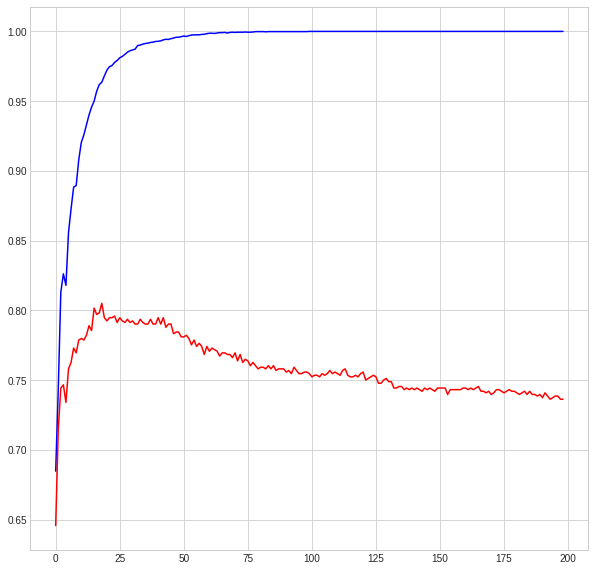

In [22]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_accs, 'b')
plt.plot(val_accs, 'r')
plt.savefig('accuracy.png', dpi = 300)

In [23]:
np.argmax(val_accs)

18

In [24]:
np.argmin(train_briers)

197

In [49]:
np.argmin(val_cross_entropys)

32

In [25]:
np.argmin(valid_briers)

18

In [29]:
np.argmin(train_adapt_rmse_eces[500])

197

In [30]:
np.argmin(train_adapt_eces[500])

197

In [32]:
np.argmin(val_adapt_eces[500])

18

In [33]:
np.argmin(val_adapt_rmse_eces[500])

18

In [34]:
np.argmin(train_abs_calibration)

198

In [35]:
np.argmin(train_mse_calibration)

198

# Brier Score

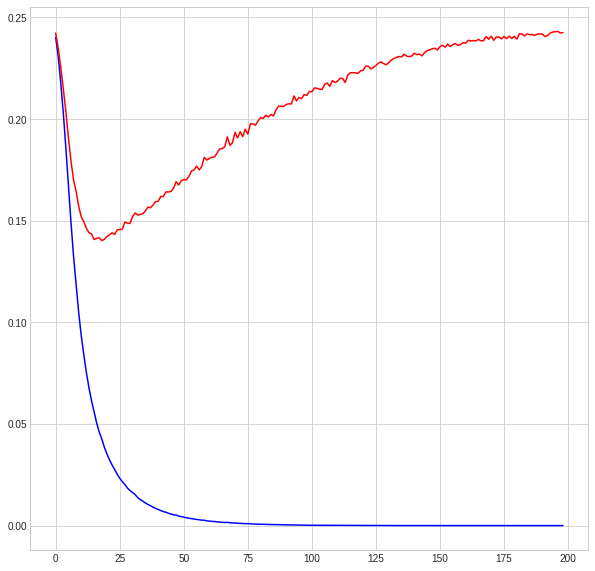

In [50]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_briers, 'b')
plt.plot(valid_briers, 'r')
plt.savefig('Briers.png', dpi = 300)

# Cross Entropy

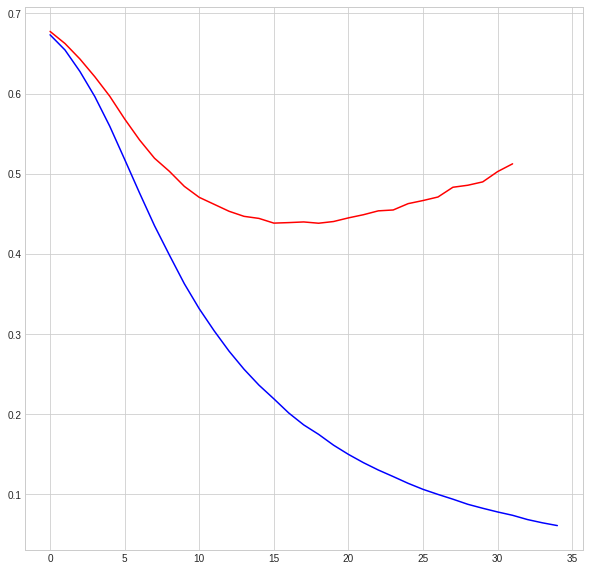

In [37]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_cross_entropys, 'b')
plt.plot(val_cross_entropys, 'r')
plt.savefig('cross entropy.png', dpi = 300)

# Adapted ECE

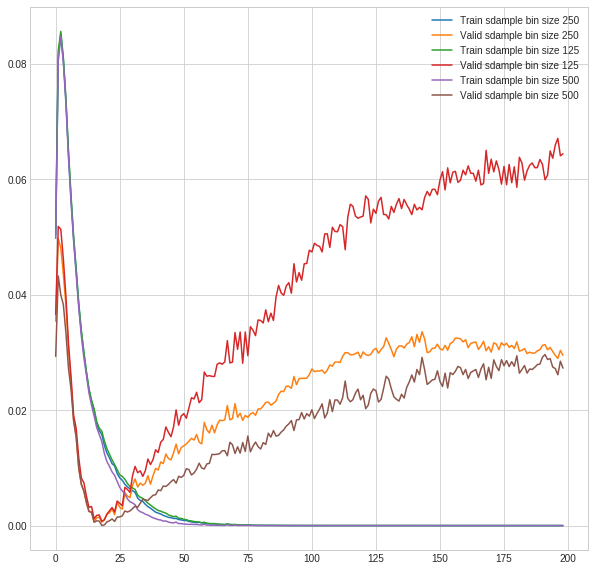

In [40]:
fig=plt.figure(figsize=(10,10))
for samples_per_bin in train_adapt_eces:
    plt.plot(train_adapt_eces[samples_per_bin], label=f'Train sdample bin size {samples_per_bin}')
    plt.plot(val_adapt_eces[samples_per_bin], label=f'Valid sdample bin size {samples_per_bin}')
plt.legend()
plt.savefig('Adapted ECE.png', dpi = 300)

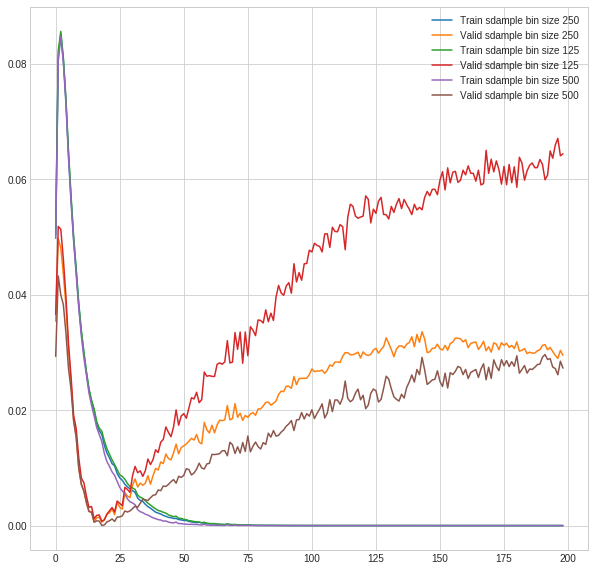

In [41]:
fig=plt.figure(figsize=(10,10))
for samples_per_bin in train_adapt_eces:
    plt.plot(train_adapt_eces[samples_per_bin], label=f'Train sdample bin size {samples_per_bin}')
    plt.plot(val_adapt_eces[samples_per_bin], label=f'Valid sdample bin size {samples_per_bin}')
plt.legend()
plt.savefig('Adapted ECE.png', dpi = 300)

# RMSE Adapted ECE

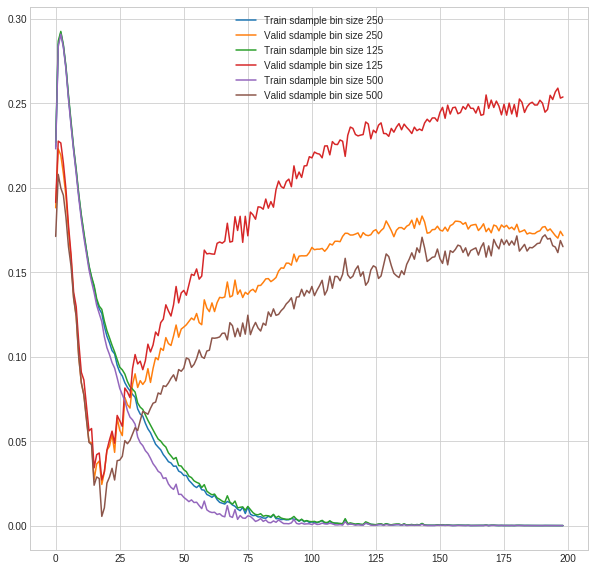

In [44]:
fig=plt.figure(figsize=(10,10))
for samples_per_bin in train_adapt_rmse_eces:
    plt.plot(train_adapt_rmse_eces[samples_per_bin], label=f'Train sdample bin size {samples_per_bin}')
    plt.plot(val_adapt_rmse_eces[samples_per_bin], label=f'Valid sdample bin size {samples_per_bin}')
plt.legend()
plt.savefig('RMSE Adapted ECE.png', dpi = 300)

# ECE

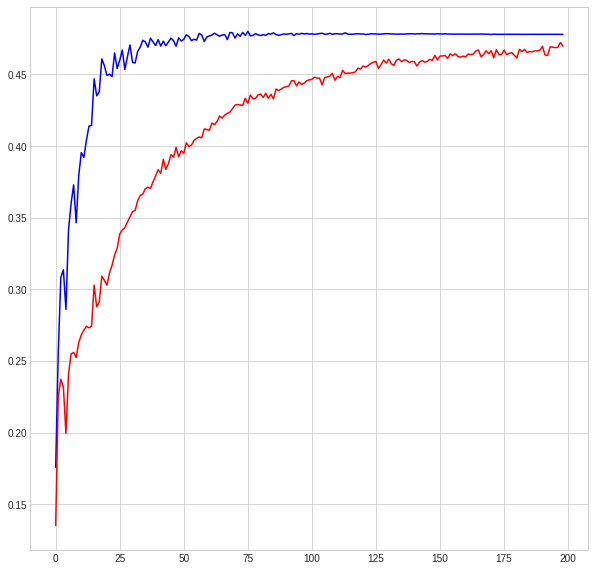

In [45]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_eces, 'b')
plt.plot(val_eces, 'r')
plt.savefig('ece.png', dpi = 300)

# MCE

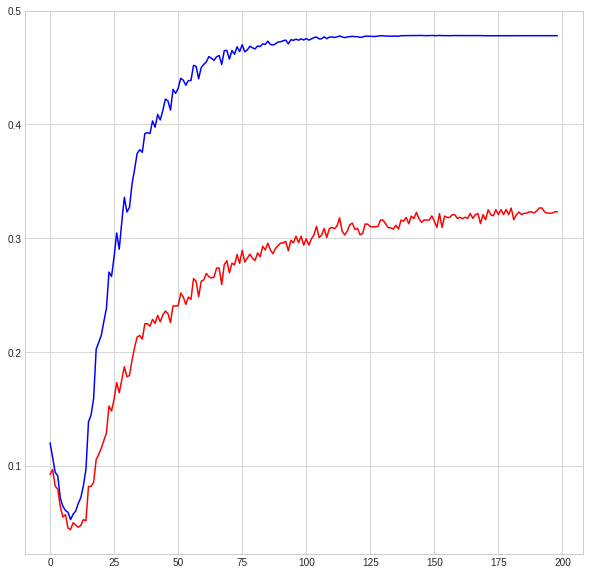

In [46]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_max_eces, 'b')
plt.plot(val_max_eces, 'r')
plt.savefig('mce.png', dpi = 300)

# ABS Calibration

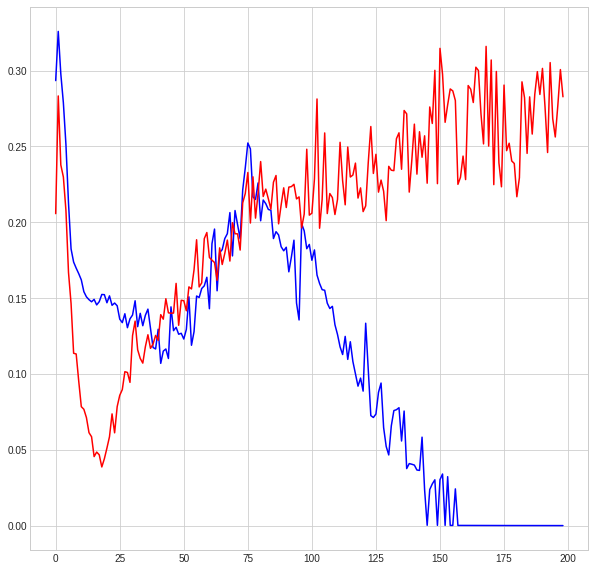

In [47]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_abs_calibration, 'b')
plt.plot(valid_abs_calibration, 'r')
plt.savefig('Absolute Calibration.png', dpi = 300)

# MSE Calibration

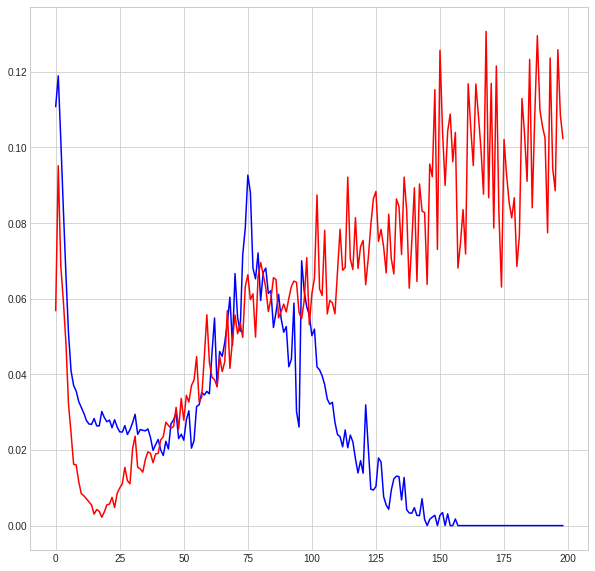

In [48]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_mse_calibration, 'b')
plt.plot(valid_mse_calibration, 'r')
plt.savefig('MSE Calibration.png', dpi = 300)

# Non-Weighted ECE

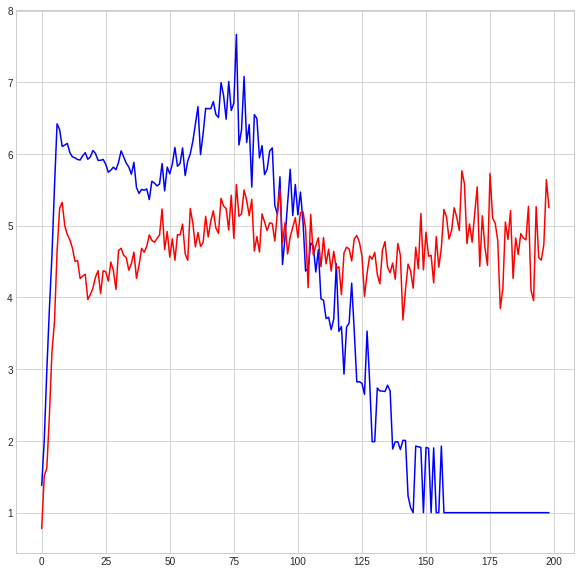

In [43]:
train_eces_non_weighted
fig=plt.figure(figsize=(10,10))
plt.plot(train_eces_non_weighted, 'b')
plt.plot(val_eces_non_weighted, 'r')
plt.savefig('non-weighted ece.png', dpi = 300)